In [1]:
import cv2
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
frames = 0; dataR=[]; dataG=[]; dataB=[]
vidcap = cv2.VideoCapture('IMG_8433.MOV')
success,img = vidcap.read()
while success:
    if 1000 <= frames and frames < 3000:
        dataB.append(average(img[400:461,400:461,0]))
        dataG.append(average(img[400:461,400:461,1]))
        dataR.append(average(img[400:461,400:461,2]))
    frames += 1; success, img = vidcap.read()
frames = len(dataB)

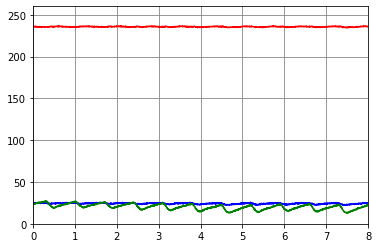

In [3]:
x = np.arange(0, 1/240*frames-1/240,1/240)
plt.ylim([0,260])
plt.xlim([0,8])
plt.grid(color='gray')
plt.plot(x, dataB, color='blue')
plt.plot(x, dataG, color='green')
plt.plot(x, dataR, color='red')

脈拍は85回/分です


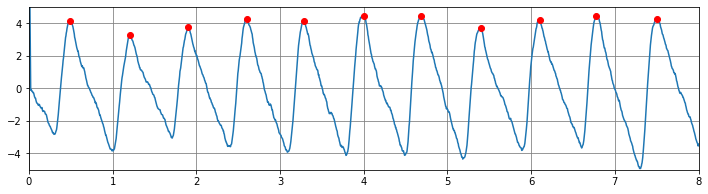

In [4]:
avedata = np.convolve(dataG, np.ones(10)/10, mode='same')
fit = np.poly1d( np.polyfit(x, avedata, 10))
data = -(avedata-fit(x))
from peakdetect import peakdetect
peaks =np.array(peakdetect(data, lookahead=30)[0])

plt.figure(figsize=(12,3))
plt.ylim([-5,5])
plt.xlim([0,8])
plt.grid(color='gray')
plt.plot(x, data)
plt.plot(1/240*peaks[:,0:1],peaks[:,1:2],'ro')

print("脈拍は{}回/分です".format(
        int(60/(1/240*average( np.diff(peaks[:,0])[1:10])))))

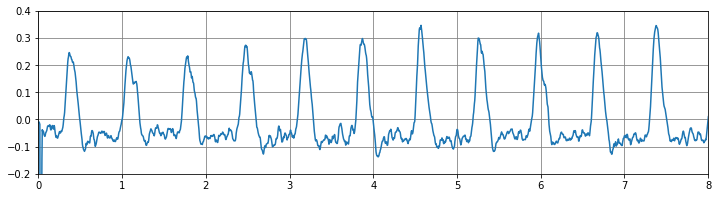

In [5]:
data = np.convolve(data, np.ones(10)/10, mode='same')
data1stD = np.gradient(data)

plt.figure(figsize=(12,3))
plt.ylim([-0.2,0.4])
plt.xlim([0,8])
plt.grid(color='gray')
plt.plot(x, data1stD)

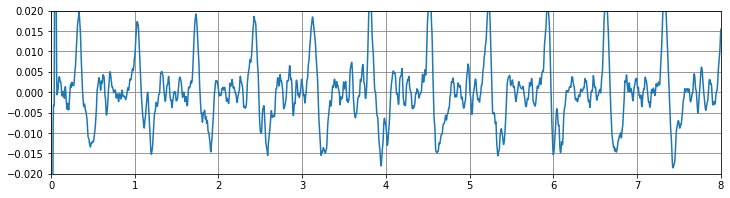

In [6]:
data1stD = np.convolve(data1stD, np.ones(10)/10, mode='same')
data2ndD=np.gradient(data1stD)

plt.figure(figsize=(12,3))
plt.ylim([-0.02,0.02])
plt.xlim([0,8])
plt.grid(color='gray')
plt.plot(x, data2ndD )

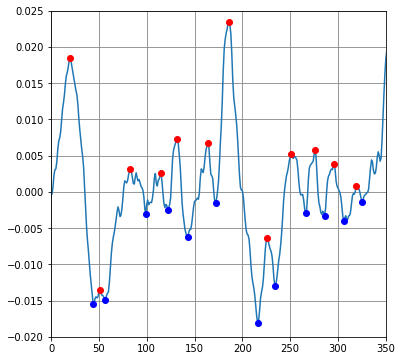

In [7]:
data2ndD=np.gradient(data1stD[730:1090]) # [730:1090]
peaksT =np.array(peakdetect(data2ndD, lookahead=8)[0])
peaksB =np.array(peakdetect(-data2ndD, lookahead=8)[0])

plt.figure(figsize=(6,6))
plt.ylim([-0.02,0.025])
plt.xlim([0,350]) # [0,350]

plt.grid(color='gray')
plt.plot(np.arange(0, len(data2ndD),1), data2ndD )
plt.plot(peaksT[:,0:1],peaksT[:,1:2],'ro')
plt.plot(peaksB[:,0:1],-peaksB[:,1:2],'bo')

In [8]:
a=[]; b=[]; c=[]; d=[]; e=[]
for i in [0,5]:
    a.append(peaksT[i,1:2])
    b.append(-peaksB[i,1:2])
    c.append(peaksT[i+1,1:2])
    d.append(-peaksB[i+1,1:2])
    e.append(peaksT[i+2,1:2])
sdptg= (average(b)-average(c)-average(d)-average(e))/average(a)

print("男性なら、血管年齢{}歳".format(int(66 + 43 * sdptg)))
print("女性なら、血管年齢{}歳".format(int(62 + 42 * sdptg)))

男性なら、血管年齢81歳
女性なら、血管年齢77歳
